## Importing Packages and Loading Data

In [5]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [6]:
df = pd.read_excel('Data/3transformasidf.xlsx', index_col='Tanggal')
y = df['RR']

In [9]:
y.head(14)

Tanggal
2014-01-01    14.20
2014-02-01     7.34
2014-03-01     7.50
2014-04-01     4.25
2014-05-01     4.86
2014-06-01     1.90
2014-07-01     1.64
2014-08-01     0.02
2014-09-01     0.00
2014-10-01     0.00
2014-11-01     3.31
2014-12-01     5.30
2015-01-01    12.80
2015-02-01    13.90
Name: RR, dtype: float64

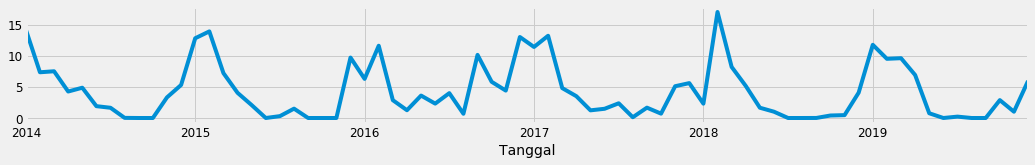

In [10]:
y.plot(figsize=(16,2))
plt.show()


## Cek stasionarity

In [30]:
from statsmodels.tsa.stattools import adfuller

X = y.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.407104
p-value: 0.000003
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591


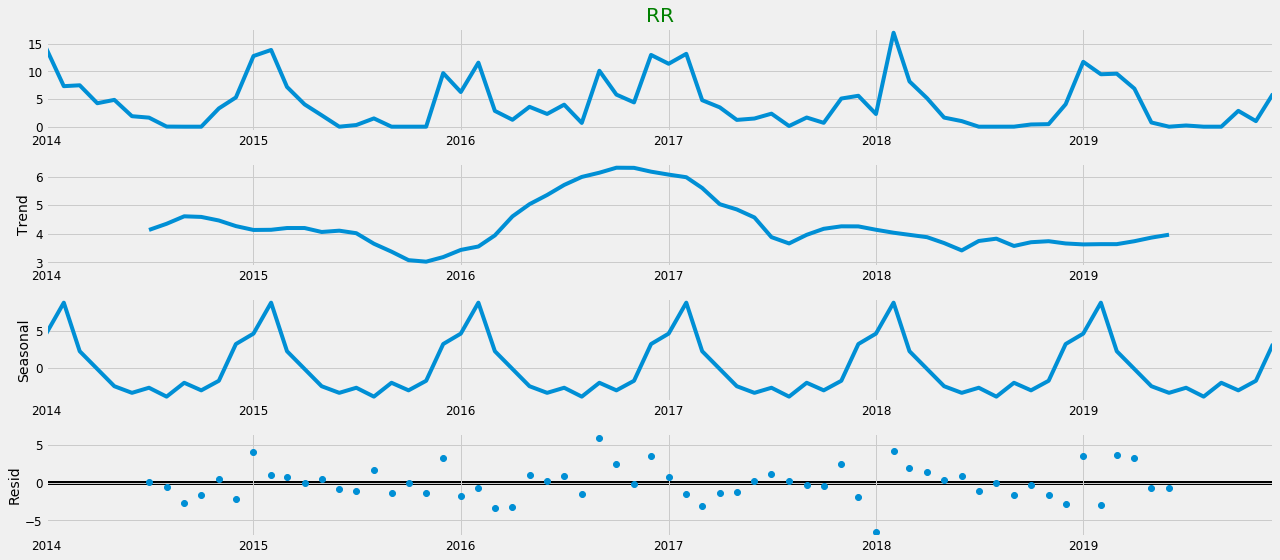

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Seleksi Parameter / Model

In [32]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [33]:
warnings.filterwarnings("ignore") 
#--------
params=[]
params_s=[]
aics=[]
#--------
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#------            
            params.append(param)
            params_s.append(param_seasonal)
            aics.append(results.aic)
#------  
        except:
            continue
print('Parameter Terbaik: ')
min_ind= aics.index(min(aics))
bestmodel= (params[min_ind], params_s[min_ind])
print('ARIMA', bestmodel,' - AIC:',min(aics))

Parameter Terbaik: 
ARIMA ((0, 1, 1), (0, 1, 1, 12))  - AIC: 237.293552493774


## Fitting Model ARIMA

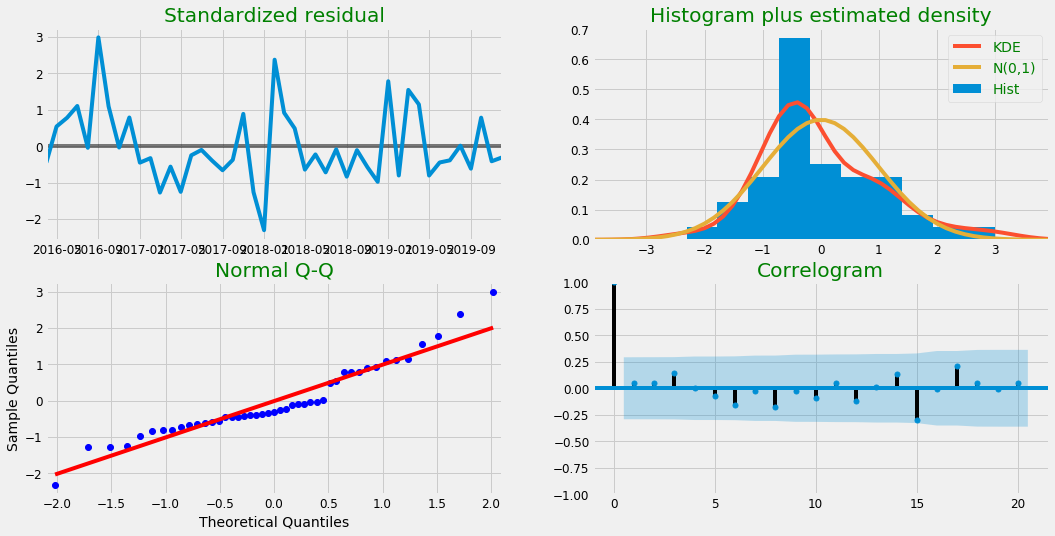

In [14]:
#dipilih yang AICnya paling kecil
# before
# order=(0, 0, 1),
# seasonal_order=(1, 1, 1, 12),
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
results.plot_diagnostics(lags=20, figsize=(16, 8))
plt.show()

## Validasi Forecasts 

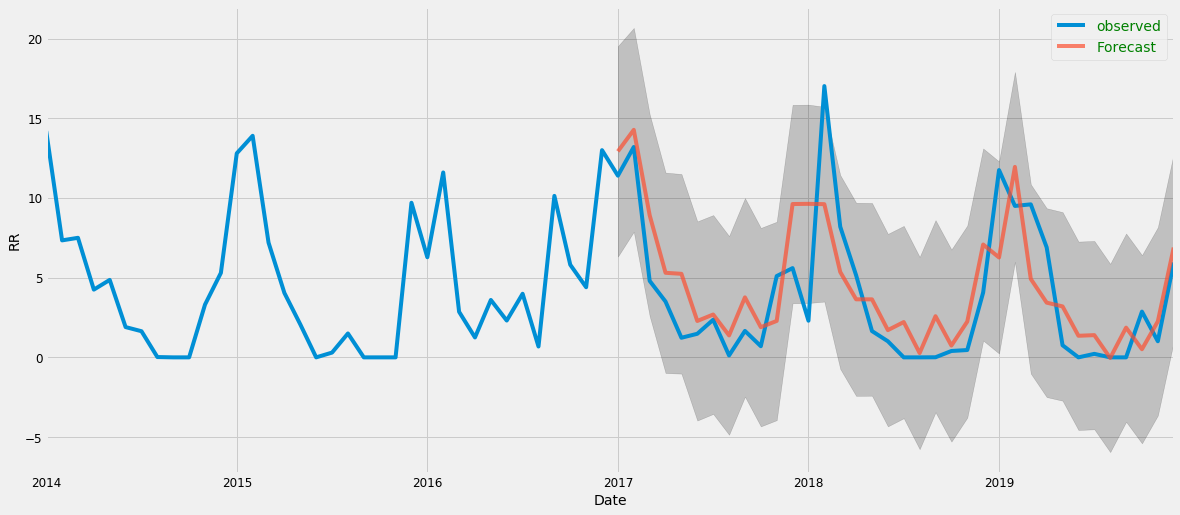

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('RR')
plt.legend()

plt.show()

In [17]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 8.61


In [18]:
print('The Root MSE of The Forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root MSE of The Forecasts is 2.94


## Visualisasi Forecasts

In [19]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()

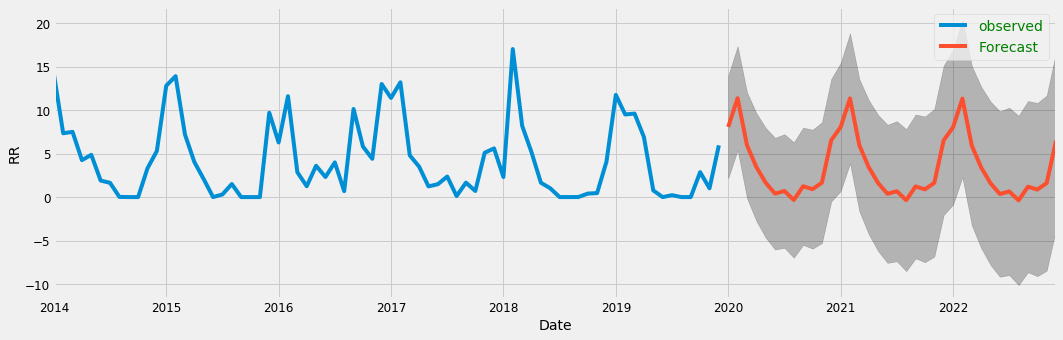

In [20]:
ax = y.plot(label='observed', figsize=(16, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)#alpha for warnanya
ax.set_xlabel('Date')
ax.set_ylabel('RR')

plt.legend()
plt.show()

In [21]:
y_forecasted = pred.predicted_mean
y_forecasted.head(20)

2017-01-01    12.925302
2017-02-01    14.274438
2017-03-01     8.918487
2017-04-01     5.305423
2017-05-01     5.241169
2017-06-01     2.282805
2017-07-01     2.688694
2017-08-01     1.377588
2017-09-01     3.763468
2017-10-01     1.894855
2017-11-01     2.285436
2017-12-01     9.619505
2018-01-01     9.632075
2018-02-01     9.611962
2018-03-01     5.356913
2018-04-01     3.641787
2018-05-01     3.640061
2018-06-01     1.709124
2018-07-01     2.215318
2018-08-01     0.270041
Freq: MS, dtype: float64

In [17]:
print(y_truth.head(12))

Tanggal
2014-01-01    14.20
2014-02-01     7.34
2014-03-01     7.50
2014-04-01     4.25
2014-05-01     4.86
2014-06-01     1.90
2014-07-01     1.64
2014-08-01     0.02
2014-09-01     0.00
2014-10-01     0.00
2014-11-01     3.31
2014-12-01     5.30
Name: RR, dtype: float64


In [22]:
pred_ci.head(24)

,lower RR,upper RR
2020-01-01,2.167305,13.971216
2020-02-01,5.396692,17.349382
2020-03-01,-0.117941,12.064021
2020-04-01,-2.742126,9.664871
2020-05-01,-4.672640,7.955384
2020-06-01,-6.026251,6.818997
2020-07-01,-5.831391,7.227467
2020-08-01,-6.968142,6.300889
2020-09-01,-5.492258,7.983667
2020-10-01,-5.930140,7.749552


In [23]:
forecast = pred_uc.predicted_mean
forecast.head(36)

2020-01-01     8.069260
2020-02-01    11.373037
2020-03-01     5.973040
2020-04-01     3.461372
2020-05-01     1.641372
2020-06-01     0.396373
2020-07-01     0.698038
2020-08-01    -0.333627
2020-09-01     1.245704
2020-10-01     0.909706
2020-11-01     1.659708
2020-12-01     6.549698
2021-01-01     8.046260
2021-02-01    11.350036
2021-03-01     5.950039
2021-04-01     3.438372
2021-05-01     1.618372
2021-06-01     0.373372
2021-07-01     0.675037
2021-08-01    -0.356627
2021-09-01     1.222704
2021-10-01     0.886705
2021-11-01     1.636707
2021-12-01     6.526697
2022-01-01     8.023259
2022-02-01    11.327036
2022-03-01     5.927039
2022-04-01     3.415371
2022-05-01     1.595371
2022-06-01     0.350372
2022-07-01     0.652037
2022-08-01    -0.379628
2022-09-01     1.199703
2022-10-01     0.863705
2022-11-01     1.613706
2022-12-01     6.503697
Freq: MS, dtype: float64

In [20]:
# forecast.to_excel('Data/hasilRRforecast_AIC237.xlsx')